<a href="https://colab.research.google.com/github/dawidstajszczyk/GSN/blob/main/Sequential_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kod na podstawie: https://www.tensorflow.org/tutorials/images/classification**

Ekstrakcja danych ze źródła: https://www.kaggle.com/datasets/dawidstajszczyk00/dice-r0ll

In [ ]:
import zipfile
import os
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import numpy as np

# Montuj Google Drive
drive.mount('/content/drive')

# Skopiuj plik kaggle.json do środowiska Colab
!cp '/content/drive/MyDrive/kaggle/kaggle.json' '/content'
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Pobierz zestaw danych
!kaggle datasets download -d dawidstajszczyk00/dice-r0ll

# Ścieżka do katalogu, gdzie znajduje się pobrany plik ZIP
zip_file_path = '/content/dice-r0ll.zip'

# Katalog docelowy dla rozpakowwanych danych
extracted_folder_path = '/content/extracted_images'

# Rozpakuj plik ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)


Mounted at /content/drive
 97% 176M/182M [00:04<00:00, 67.8MB/s]
100% 182M/182M [00:04<00:00, 45.9MB/s]


Ładowanie danych z użyciem Keras Utility

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = '/content/extracted_images/dataset'

batch_size = 32
img_height = 256
img_width = 256

# Stwórz obiekt tf.data.Dataset
dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True, # Mieszanie danych
  image_size=(img_height, img_width),
  batch_size=batch_size
  )


Found 599 files belonging to 6 classes.


Podział danych na zbiór treningowy, walidacyjny i testowy w proporcji 60:20:20

In [ ]:
import math

# Ustal rozmiar poszczególnych zbiorów danych
dataset_size = len(dataset) # Obiekt 'dataset' składa się z batch'y. Batch = 32 obrazy
train_size = int(0.6 * dataset_size)
val_size = math.ceil(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Podział na dane treningowe, walidacyjne i testowe
train_ds = dataset.take(train_size)
temp_ds = dataset.skip(train_size)
val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

Podgląd danych

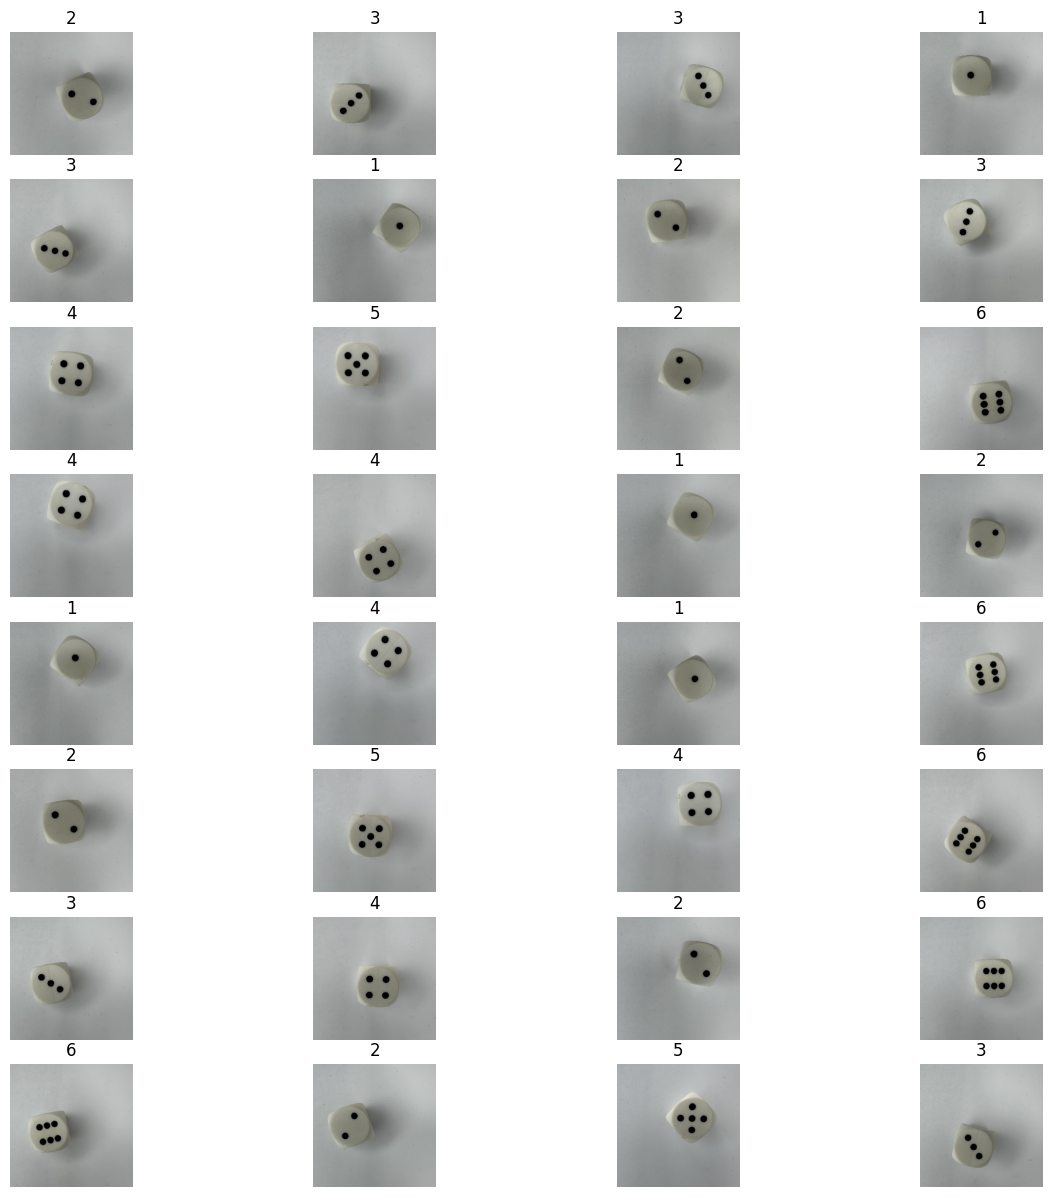

In [ ]:
import matplotlib.pyplot as plt

# Pobierz etykiety klas
class_names = dataset.class_names

# Wyświetl pierwszy batch
for images, labels in test_ds:
    plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()
    break;


Konfiguracja danych pod kątem wydajności

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Przybliżona ilość obrazów w zbiorze danych
img_number = (tf.data.experimental.cardinality(dataset).numpy())*batch_size

train_ds = train_ds.cache()
train_ds = train_ds.shuffle(2*img_number)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache()
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache()
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Tworzenie modelu

In [ ]:
import keras
from keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Normalizacja danych
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2), # Dropout zapobiega overfittingowi.
  layers.Dense(num_classes, activation='softmax')
])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

Kompilacja modelu

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Trening modelu

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 54s 4s/step - loss: 2.3957 - accuracy: 0.1733 - val_loss: 1.7942 - val_accuracy: 0.1875
Epoch 2/10
11/11 [==============================] - 29s 3s/step - loss: 1.7921 - accuracy: 0.1761 - val_loss: 1.7751 - val_accuracy: 0.2500
Epoch 3/10
11/11 [==============================] - 26s 2s/step - loss: 1.6844 - accuracy: 0.3068 - val_loss: 1.5206 - val_accuracy: 0.4141
Epoch 4/10
11/11 [==============================] - 26s 2s/step - loss: 1.3089 - accuracy: 0.5312 - val_loss: 1.0885 - val_accuracy: 0.6094
Epoch 5/10
11/11 [==============================] - 40s 4s/step - loss: 0.9249 - accuracy: 0.6449 - val_loss: 0.7919 - val_accuracy: 0.6641
Epoch 6/10
11/11 [==============================] - 33s 3s/step - loss: 0.6138 - accuracy: 0.7812 - val_loss: 0.7507 - val_accuracy: 0.7266
Epoch 7/10
11/11 [==============================] - 28s 3s/step - loss: 0.4972 - accuracy: 0.8239 - val_loss: 0.7512 - val_accuracy: 0.7031
Epoch 8/10
11/11 [==

Predykcja na zbiorze testowym


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_ds)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

misclassified_indices = np.where(predicted_labels != true_labels)[0]

print(classification_report(true_labels, predicted_labels))

for i in range(len(true_labels)):
    true_label = int(true_labels[i])
    predicted_label = predicted_labels[i]

    # Wyświetl informacje o próbce
    print(f'True class: {true_label+1} Predicted class: {predicted_label+1}')


4/4 [==============================] - 3s 757ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.55      0.92      0.69        13
           2       1.00      0.67      0.80        21
           3       0.73      0.76      0.74        21
           4       0.67      0.53      0.59        19
           5       0.84      0.88      0.86        24

    accuracy                           0.77       119
   macro avg       0.78      0.78      0.76       119
weighted avg       0.80      0.77      0.77       119

True class: 3 Predicted class: 3
True class: 5 Predicted class: 4
True class: 6 Predicted class: 6
True class: 4 Predicted class: 4
True class: 4 Predicted class: 2
True class: 4 Predicted class: 4
True class: 5 Predicted class: 5
True class: 5 Predicted class: 5
True class: 2 Predicted class: 2
True class: 4 Predicted class: 5
True class: 5 Predicted class: 4
True class: 1 Predicted class: 1
True cla

**Uwagi**



*   Dodanie augumentacji nie powoduje wzrostu dokładności na zbiorze walidacyjnym ani testowym.
*   Liczba epok (=10) jest wystarczająca, gdyż w przypadku jej wzrostu val_accuracy nie zmienia się

